# Method: Koopman Autoencoders
# Dataset: Lorenz-96, F = 8
# Purpose: Prediction

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time, localtime, strftime

from functools import partial

import jax
from jax import jit, value_and_grad
import jax.numpy as jnp
from jax import random
from jax.example_libraries import optimizers
import jax.example_libraries.stax as stax
from jax.example_libraries.stax import Dense, Relu, Tanh
from jax.nn.initializers import glorot_normal

In [3]:
SEED = 42

In [4]:
train, test = load_data("Lorenz 96, F = 8", "../../data/lorenz8", 0.5)

In [5]:
train.data = train.data[:13500]
train.time = train.time[:13500]

In [6]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (13500, 40)
Test size: (90000, 40)


**Create test set**

In [7]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [8]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 200 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [9]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 40)
Test output size: (100, 400, 40)


# 2. Koopman Autoencoder Implementation

In [10]:
def Dense_no_bias(out_dim, W_init = glorot_normal()):
    """Layer constructor function for a dense (fully-connected) layer."""
    def init_fun(rng, input_shape):
        output_shape = input_shape[:-1] + (out_dim,)
        k1, k2 = random.split(rng)
        W = W_init(k1, (input_shape[-1], out_dim))
        return output_shape, W
    def apply_fun(params, inputs, **kwargs):
        W = params
        return jnp.dot(inputs, W)
    return init_fun, apply_fun

In [11]:
def get_params(hidden_state_list, max_lag, lambda_list, seed, batch_size, num_epoch, lr_schedule, 
               early_stopping = EARLY_STOPPING):
    assert len(num_epoch) == len(lr_schedule)
    
    def create_network():
        encoder_init, encoder = stax.serial(
            Dense(p1), Tanh,  
            Dense(p2), Tanh,
            Dense(p3), Tanh,
            Dense(kappa))
        decoder_init, decoder = stax.serial(
            Dense(p3), Tanh,
            Dense(p2), Tanh,
            Dense(p1), Tanh,
            Dense(data_dim))
        forward_init, forward = stax.serial(
            Dense_no_bias(kappa))
        backward_init, backward = stax.serial(
            Dense_no_bias(kappa))

        # initialization
        enc_init_rng, dec_init_rng, forward_init_rng, backward_init_rng = random.split(key, num = 4)

        enc_in_shape = (-1, data_dim)
        dec_in_shape = (-1, kappa)
        forward_in_shape = (-1, kappa)
        backward_in_shape = (-1, kappa)
        _, enc_params = encoder_init(enc_init_rng, enc_in_shape)
        _, dec_params = decoder_init(dec_init_rng, dec_in_shape)
        _, fwd_params = forward_init(forward_init_rng, forward_in_shape)
        _, bwd_params = backward_init(backward_init_rng, backward_in_shape)

        network = (encoder, decoder, forward, backward)
        params = (enc_params, dec_params, fwd_params, bwd_params)
        return network, params
    
    def training(init_params):
        @jit
        def loss(params, batch):
            """
            each batch has dimension Batch_size x (max_lag+1) x dim
            """
            # unpack parameters
            enc_params, dec_params, fwd_params, bwd_params = params
            lambda_id, lambda_fwd, lambda_bwd, lambda_con = lambda_list

            loss_id, loss_fwd, loss_bwd, loss_con = 0, 0, 0, 0

            # AUTOENCODER
            f_start = batch[:,0,:]
            f_target = batch[:,0,:]
            f_encoded = encoder(enc_params, f_start)
            f_predict = decoder(dec_params, f_encoded)
            loss_id = 0.5 * jnp.mean((f_predict - f_target)**2)

            # FORWARD
            f_start = batch[:,0,:]
            f_encoded = encoder(enc_params, f_start)
            for t_steps in range(1, max_lag+ 1):
                # simulate forward
                f_encoded = forward(fwd_params, f_encoded)
                f_predict = decoder(dec_params, f_encoded)
                f_target = batch[:,t_steps,:]
                loss_fwd += 0.5 * jnp.mean((f_predict - f_target)**2)

            loss_fwd = loss_fwd / max_lag

            # BACKWARD
            f_start = batch[:,-1,:]
            f_encoded = encoder(enc_params, f_start)
            for t_steps in range(1, max_lag + 1):
                f_encoded = backward(bwd_params, f_encoded)
                f_predict = decoder(dec_params, f_encoded)
                f_target = batch[:,-t_steps-1,:]
                loss_bwd += 0.5 * jnp.mean((f_predict - f_target)**2)

            loss_bwd = loss_bwd / max_lag

            # CONSISTENT
            for k in range(1, kappa + 1):
                C_upper = fwd_params[0][:k, :]
                D_left = bwd_params[0][:, :k]
                C_left = fwd_params[0][:, :k]
                D_upper = bwd_params[0][:k, :]

                I_k = jnp.identity(k)

                loss_con += (jnp.sum((D_upper @ C_left - I_k)**2) + jnp.sum((C_upper @ D_left - I_k)**2)) / (2 * k)

            return lambda_id * loss_id + lambda_fwd * loss_fwd + lambda_bwd * loss_bwd + lambda_con * loss_con
    
        @jit
        def step(i, opt_state, batch):
            params = get_params(opt_state)
            value, g = value_and_grad(loss)(params, batch)
            opt_state = opt_update(i, g, opt_state)
            return get_params(opt_state), opt_state, value
        
        def make_forecast(params, batch, L_forecast):
            enc_params, dec_params, fwd_params, bwd_params = params

            preds = []
            f_start = batch[:, 0, :]
            f_encoded = encoder(enc_params, f_start)
            for t in range(L_forecast):
                f_encoded = forward(fwd_params, f_encoded)
                f_predict = decoder(dec_params, f_encoded)
                preds.append(f_predict)
            return np.swapaxes(preds, 0, 1)      
        
        def mse(params, x_batch, y_truth):
            """
            For each time-series in a batch, forecasts over a finite horizon 
            and compute the MSE. Primarily used for validation calculation

            args:
            ====
             params: neural parameters
             x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
             y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

            outputs:
            =======
             MSE: MSE between forecasts and targets
            """

            # horizon of the forecast
            L_forecast = y_truth.shape[1]    
            y_pred = make_forecast(params, x_batch, L_forecast_test)
            
            #compute MSE
            error = y_pred - y_truth
            mu_loss = np.mean(error**2)
            return mu_loss 
        
        start = time()
        best_params = init_params
        overall_best_mse = 99999999
        
        # train/val split
        t_size = int(0.9 * train_size)
        v_size = train_size - t_size
        T_indices_val = np.arange(t_size, train_size - (L_forecast_test + max_lag))
        t_start_val = T_indices_val[::10]
        t_past_batch_val = (t_start_val[:,None] + np.arange(max_lag)[None,:]).astype(int) 
        t_pred_batch_val = (t_start_val[:,None] + np.arange(max_lag, max_lag + L_forecast_test)[None,:]).astype(int) 
        x_val = x[t_past_batch_val]
        y_val = y[t_pred_batch_val]
        
        print("Backpropogation start", end = "\n\n")
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init(best_params)
            counter = 0
            best_mse = 999999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                # randomize the order of the data
                T_indices = np.arange(t_size - max_lag - 1)
                np.random.shuffle(T_indices)
                
                # training
                loss_epoch_train = []
                
                for k in range(t_size // batch_size + 1):
                    # create a batch of data
                    t_start = T_indices[np.arange(k*batch_size, (k+1)*batch_size).astype(int) % len(T_indices)] # start of each time series in the batch

                    # create 2d array of dimension (batch_size, max_lag + 1) containing all the time indices
                    t_batch = (t_start[:,None] + np.arange(max_lag + 1)[None,:]).astype(int) # transposes data

                    #create batch of dimension (batch_size,  max_lag + 1, data_dim)
                    x_batch = x[t_batch]  

                    params, opt_state, loss_current = step(k, opt_state, x_batch)
                    loss_epoch_train.append(loss_current.item())
                
                mse_train = np.mean(loss_epoch_train)

                # validation
                mse_val = mse(params, x_val, y_val)
                
                if best_mse > mse_val: # Improvement
                    counter = 0
                    best_mse = mse_val
                    best_params = params
                else:
                    counter += 1
                
                e_end = time()
                if (epoch + 1) % 10 == 0 or (counter == 0 and epoch >= 30):
                    print(f"Epoch {epoch + 1}: Time taken = {e_end - e_start:.2f} | Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                if counter >= early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                    break
            
            print(f"Best Validation MSE: {best_mse:.7f}")
            
            if best_mse < overall_best_mse: # Best round so far
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_mse
                overall_best_params = best_params
            print()
            
        end = time()
        print(f"Total time: {end - start:.2f}")

        return overall_best_params
            
    start = time()
    x, y = train.data[:-1], train.data[1:]
    train_size, data_dim = x.data.shape
    p1, p2, p3, kappa = hidden_state_list # 4 layers (including bottleneck)
        
    np.random.seed(seed)
    key = jax.random.PRNGKey(seed)
    
    (encoder, decoder, forward, backward), params = create_network()
    final_params = training(params)
    
    return final_params, (encoder, decoder, forward, backward)

In [12]:
def get_test_pred(data_test, params, network):
    start = time()
    
    (encoder, decoder, forward, backward) = network
    enc_params, dec_params, fwd_params, bwd_params = params
    
    num_data_test, L_past, data_dim = data_test.shape # testing ex, # steps used before, dim of data

    preds = []
    f_start = data_test[:, 0, :]
    f_encoded = encoder(enc_params, f_start)
    for t in range(L_forecast_test):
        f_encoded = forward(fwd_params, f_encoded)
        f_predict = decoder(dec_params, f_encoded)
        preds.append(f_predict)
    
    end = time()
    print(f"Time taken: {end - start:.2f}")
    return np.swapaxes(preds, 0, 1)

# 3. Parameter tuning

There are 3 parameters to tune
- hidden_size - size of the hidden layer
- max_lag - Number of steps calculated for forward and backward dynamics
- loss_weights - [encoder, forward, backward, consistent] loss

## 3.1 hidden_size

**Parameters**
- hidden_size varied
- max_lag = 8
- loss_weights = [1, 1, 0.1, 0.01]

In [13]:
max_lag = 8
loss_weights = [1, 1, .1, .01]

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

In [14]:
res_folder = os.path.join("results", "koopman")

### 3.1.1 hidden_size = [32, 16, 16, 8]

In [15]:
hidden_size = [32, 16, 16, 8]

In [16]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.56 | Train loss = 0.8268199 | Val loss =  0.9966321
Epoch 20: Time taken = 0.60 | Train loss = 0.7638602 | Val loss =  1.0982633
Epoch 30: Time taken = 0.56 | Train loss = 0.7490570 | Val loss =  1.0268586
Epoch 40: Time taken = 0.59 | Train loss = 0.7404042 | Val loss =  0.9929755
Epoch 41: Time taken = 0.59 | Train loss = 0.7387045 | Val loss =  0.9850292
Epoch 43: Time taken = 0.57 | Train loss = 0.7311161 | Val loss =  0.9782318
Epoch 50: Time taken = 0.58 | Train loss = 0.7163510 | Val loss =  1.1876753
Best Validation MSE: 0.9782318
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.58 | Train loss = 0.7106120 | Val loss =  1.0798134
Epoch 20: Time taken = 0.56 | Train loss = 0.6865954 | Val loss =  1.3760885
Epoch 30: Time taken = 0.58 | Train loss = 0.6805631 | Val loss =  1.3320641
Epoch 40: Time taken = 0.56 | Train loss = 0.6777957 | Val loss =  1.4333456
EARLY STOPPING. Epoch 46: Train loss = 0.6758367 | Val loss =  1.5173005
B

In [17]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.93


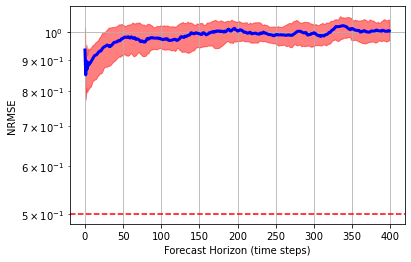

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.932
Median NRMSE at t = 0.5: 0.978
Median NRMSE at t = 1: 0.975
Median NRMSE at t = 2: 1.005
Median NRMSE at t = 3: 0.999


In [18]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.2 hidden_size = [16, 8, 8, 4]

In [19]:
hidden_size = [16, 8, 8, 4]

In [20]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.58 | Train loss = 0.9402131 | Val loss =  1.0033593
Epoch 20: Time taken = 0.60 | Train loss = 0.8950122 | Val loss =  0.9930701
Epoch 30: Time taken = 0.65 | Train loss = 0.8850481 | Val loss =  0.9928275
Epoch 31: Time taken = 0.61 | Train loss = 0.8835333 | Val loss =  0.9924106
Epoch 32: Time taken = 0.56 | Train loss = 0.8812709 | Val loss =  0.9921691
Epoch 33: Time taken = 0.63 | Train loss = 0.8778096 | Val loss =  0.9908435
Epoch 34: Time taken = 0.81 | Train loss = 0.8722862 | Val loss =  0.9890375
Epoch 35: Time taken = 0.73 | Train loss = 0.8674981 | Val loss =  0.9872407
Epoch 40: Time taken = 0.72 | Train loss = 0.8605941 | Val loss =  1.2190683
Epoch 50: Time taken = 0.70 | Train loss = 0.8559196 | Val loss =  1.1474951
Best Validation MSE: 0.9872407
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.58 | Train loss = 0.8551506 | Val loss =  1.1551455
Epoch 20: Time taken = 0.59 | Train loss = 0.8524329 | Val loss =  1.11789

In [21]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.46


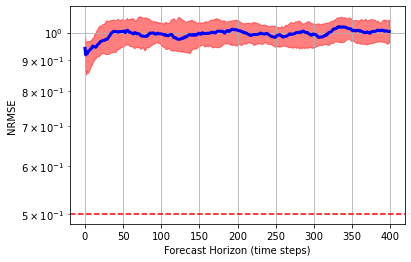

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.966
Median NRMSE at t = 0.5: 1.004
Median NRMSE at t = 1: 0.995
Median NRMSE at t = 2: 1.009
Median NRMSE at t = 3: 0.995


In [22]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.3 hidden_size = [64, 128, 128, 256]

In [23]:
hidden_size = [64, 128, 128, 256]

In [24]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 2.53 | Train loss = 0.0491519 | Val loss =  1.9404031
Epoch 20: Time taken = 2.51 | Train loss = 0.0321003 | Val loss =  2.0858190
Epoch 30: Time taken = 2.39 | Train loss = 0.0270290 | Val loss =  1.9702631
EARLY STOPPING. Epoch 31: Train loss = 0.0265810 | Val loss =  2.1340023
Best Validation MSE: 1.6353009
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 2.43 | Train loss = 0.0386590 | Val loss =  1.8195534
Epoch 20: Time taken = 2.38 | Train loss = 0.0293598 | Val loss =  2.1811133
Epoch 30: Time taken = 2.50 | Train loss = 0.0253390 | Val loss =  2.3255669
EARLY STOPPING. Epoch 32: Train loss = 0.0246796 | Val loss =  2.4087258
Best Validation MSE: 1.5994154
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 2.50 | Train loss = 0.0324437 | Val loss =  1.9642173
Epoch 20: Time taken = 2.39 | Train loss = 0.0266572 | Val loss =  2.3267611
Epoch 30: Time taken = 2.44 | Train loss = 0.0233879 | Val loss =  2.2952435
EARLY STOPPING. Epoch 34: 

In [25]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.83


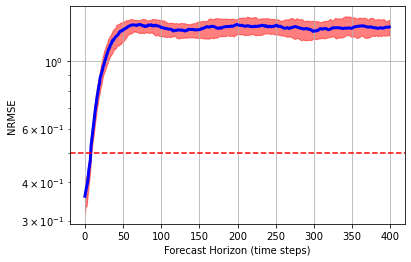

It takes around t = 0.08 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.881
Median NRMSE at t = 0.5: 1.264
Median NRMSE at t = 1: 1.286
Median NRMSE at t = 2: 1.315
Median NRMSE at t = 3: 1.253


In [26]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.4 hidden_size = [32, 24, 24, 16]

In [27]:
hidden_size = [32, 24, 24, 16]

In [28]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.66 | Train loss = 0.6876706 | Val loss =  0.9928799
Epoch 20: Time taken = 0.64 | Train loss = 0.5926434 | Val loss =  1.0541582
Epoch 30: Time taken = 0.69 | Train loss = 0.5661305 | Val loss =  1.0098254
EARLY STOPPING. Epoch 37: Train loss = 0.5556736 | Val loss =  0.9827854
Best Validation MSE: 0.9820176
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.65 | Train loss = 0.5793107 | Val loss =  1.0288351
Epoch 20: Time taken = 0.66 | Train loss = 0.5589390 | Val loss =  0.9994376
Epoch 30: Time taken = 0.66 | Train loss = 0.5297984 | Val loss =  1.0310467
Epoch 40: Time taken = 0.66 | Train loss = 0.5195458 | Val loss =  1.0307569
Epoch 50: Time taken = 0.66 | Train loss = 0.5067906 | Val loss =  0.9822482
Best Validation MSE: 0.9743868
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.65 | Train loss = 0.5179777 | Val loss =  1.0861248
Epoch 20: Time taken = 0.65 | Train loss = 0.5031886 | Val loss =  0.9965472
Epoch 30: Time taken =

In [29]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.52


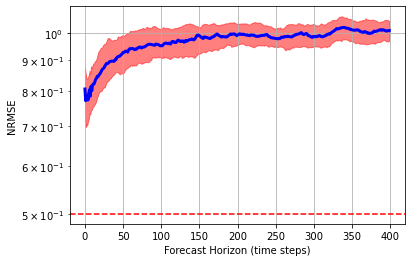

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.856
Median NRMSE at t = 0.5: 0.928
Median NRMSE at t = 1: 0.952
Median NRMSE at t = 2: 0.991
Median NRMSE at t = 3: 0.987


In [30]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.5 hidden_size = [36, 32, 32, 24]

In [31]:
hidden_size = [36, 32, 32, 24]

In [32]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.69 | Train loss = 0.5769323 | Val loss =  0.9782615
Epoch 20: Time taken = 0.69 | Train loss = 0.4739190 | Val loss =  1.0104958
Epoch 30: Time taken = 0.67 | Train loss = 0.4353200 | Val loss =  1.0177829
Epoch 40: Time taken = 0.68 | Train loss = 0.4155140 | Val loss =  1.0264393
Epoch 50: Time taken = 0.69 | Train loss = 0.3954760 | Val loss =  1.3089518
Best Validation MSE: 0.9639194
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.68 | Train loss = 0.4058604 | Val loss =  1.0986761
Epoch 20: Time taken = 0.68 | Train loss = 0.3745936 | Val loss =  1.5282225
Epoch 30: Time taken = 0.67 | Train loss = 0.3638720 | Val loss =  1.7762161
EARLY STOPPING. Epoch 31: Train loss = 0.3632363 | Val loss =  1.8796505
Best Validation MSE: 1.0098770

Epoch 10: Time taken = 0.67 | Train loss = 0.3950183 | Val loss =  1.3975923
Epoch 20: Time taken = 0.67 | Train loss = 0.3696153 | Val loss =  1.6971016
Epoch 30: Time taken = 0.66 | Train loss = 0.3

In [33]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.51


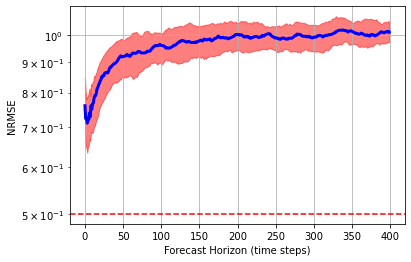

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.837
Median NRMSE at t = 0.5: 0.920
Median NRMSE at t = 1: 0.961
Median NRMSE at t = 2: 1.002
Median NRMSE at t = 3: 0.992


In [34]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.6 hidden_size = [40, 40, 40, 40]

In [35]:
hidden_size = [40, 40, 40, 40]

In [36]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.75 | Train loss = 0.4476190 | Val loss =  1.0044736
Epoch 20: Time taken = 0.73 | Train loss = 0.3630739 | Val loss =  1.0505005
Epoch 30: Time taken = 0.72 | Train loss = 0.3243328 | Val loss =  1.2415519
EARLY STOPPING. Epoch 38: Train loss = 0.3079382 | Val loss =  1.4093700
Best Validation MSE: 0.9863345
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.72 | Train loss = 0.3435079 | Val loss =  1.1389411
Epoch 20: Time taken = 0.73 | Train loss = 0.3108157 | Val loss =  1.4038996
Epoch 30: Time taken = 0.73 | Train loss = 0.2931560 | Val loss =  1.7402953
EARLY STOPPING. Epoch 36: Train loss = 0.2799397 | Val loss =  1.8750377
Best Validation MSE: 1.0397495

Epoch 10: Time taken = 0.73 | Train loss = 0.3083149 | Val loss =  1.6361378
Epoch 20: Time taken = 0.73 | Train loss = 0.2860815 | Val loss =  1.9332184
Epoch 30: Time taken = 0.73 | Train loss = 0.2643665 | Val loss =  1.8168000
EARLY STOPPING. Epoch 33: Train loss = 0.2558219 |

In [37]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.36


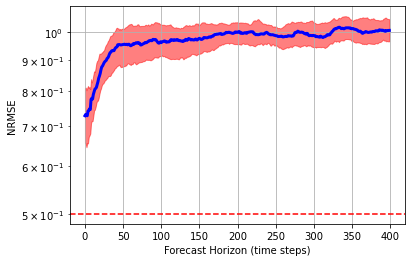

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.855
Median NRMSE at t = 0.5: 0.954
Median NRMSE at t = 1: 0.961
Median NRMSE at t = 2: 1.000
Median NRMSE at t = 3: 0.988


In [38]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.2 max_lag

In [39]:
loss_weights = [1, 1, .1, .01]
hidden_size = [36, 32, 32, 24]

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

### 3.2.1 max_lag = 4

In [40]:
max_lag = 4

In [41]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.62 | Train loss = 0.5430006 | Val loss =  1.4441712
Epoch 20: Time taken = 0.63 | Train loss = 0.4421341 | Val loss =  1.6262210
Epoch 30: Time taken = 0.63 | Train loss = 0.4092145 | Val loss =  1.4862158
EARLY STOPPING. Epoch 32: Train loss = 0.4027440 | Val loss =  1.2896009
Best Validation MSE: 1.0077558
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.64 | Train loss = 0.4679458 | Val loss =  1.6728434
Epoch 20: Time taken = 0.63 | Train loss = 0.4163813 | Val loss =  1.4463031
Epoch 30: Time taken = 0.65 | Train loss = 0.3981969 | Val loss =  1.5616478
EARLY STOPPING. Epoch 32: Train loss = 0.3944805 | Val loss =  1.7820208
Best Validation MSE: 1.0763064

Epoch 10: Time taken = 0.63 | Train loss = 0.4304867 | Val loss =  1.5336716
Epoch 20: Time taken = 0.79 | Train loss = 0.4036208 | Val loss =  1.4357831
Epoch 30: Time taken = 0.74 | Train loss = 0.3806881 | Val loss =  1.8144993
Epoch 40: Time taken = 0.79 | Train loss = 0.36741

In [42]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.26


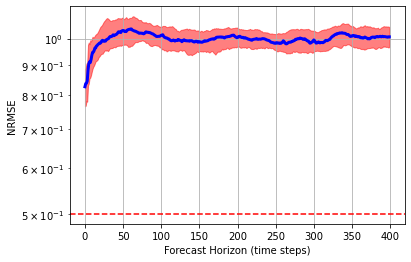

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.982
Median NRMSE at t = 0.5: 1.033
Median NRMSE at t = 1: 1.014
Median NRMSE at t = 2: 1.005
Median NRMSE at t = 3: 0.995


In [43]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.2 max_lag = 8
This is already done in 3.1.5

### 3.2.3 max_lag = 16

In [44]:
max_lag = 16

In [45]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.74 | Train loss = 0.6065581 | Val loss =  0.9908863
Epoch 20: Time taken = 0.74 | Train loss = 0.5469917 | Val loss =  0.9840692
Epoch 30: Time taken = 0.75 | Train loss = 0.5063068 | Val loss =  0.9835677
Epoch 36: Time taken = 0.73 | Train loss = 0.4859212 | Val loss =  0.9804094
Epoch 40: Time taken = 0.73 | Train loss = 0.4798760 | Val loss =  0.9918214
Epoch 43: Time taken = 0.72 | Train loss = 0.4726020 | Val loss =  0.9755289
Epoch 50: Time taken = 0.75 | Train loss = 0.4535949 | Val loss =  0.9771524
Best Validation MSE: 0.9755289
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.74 | Train loss = 0.4350154 | Val loss =  1.0511480
Epoch 20: Time taken = 0.86 | Train loss = 0.4241005 | Val loss =  1.0537135
Epoch 30: Time taken = 0.88 | Train loss = 0.4138498 | Val loss =  1.1244452
EARLY STOPPING. Epoch 33: Train loss = 0.4115123 | Val loss =  1.1426246
Best Validation MSE: 0.9722368
IMPROVED VALIDATION MSE

Epoch 10: Time taken =

In [46]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.23


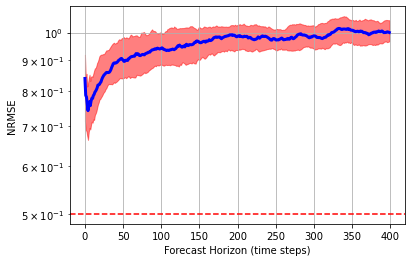

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.825
Median NRMSE at t = 0.5: 0.900
Median NRMSE at t = 1: 0.942
Median NRMSE at t = 2: 0.987
Median NRMSE at t = 3: 0.988


In [47]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.4 max_lag = 24

In [48]:
max_lag = 24

In [49]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.82 | Train loss = 0.6370115 | Val loss =  0.9992232
Epoch 20: Time taken = 0.84 | Train loss = 0.5611497 | Val loss =  1.0020949
Epoch 30: Time taken = 0.98 | Train loss = 0.5426191 | Val loss =  1.0038120
Epoch 40: Time taken = 0.87 | Train loss = 0.5300055 | Val loss =  1.0134043
EARLY STOPPING. Epoch 41: Train loss = 0.5279807 | Val loss =  1.0065506
Best Validation MSE: 0.9959917
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.96 | Train loss = 0.5456486 | Val loss =  1.0041234
Epoch 20: Time taken = 1.00 | Train loss = 0.5322580 | Val loss =  1.0086797
Epoch 30: Time taken = 0.97 | Train loss = 0.5167107 | Val loss =  1.0040101
Epoch 40: Time taken = 0.99 | Train loss = 0.4950416 | Val loss =  1.0084671
EARLY STOPPING. Epoch 46: Train loss = 0.4807360 | Val loss =  1.0183870
Best Validation MSE: 0.9984983

Epoch 10: Time taken = 0.97 | Train loss = 0.5135409 | Val loss =  1.0059655
Epoch 20: Time taken = 0.97 | Train loss = 0.48643

In [50]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.29


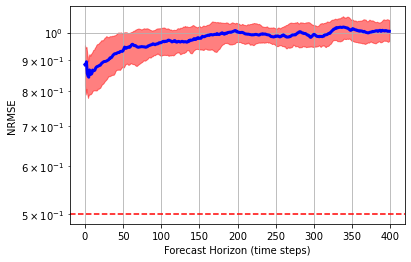

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.883
Median NRMSE at t = 0.5: 0.933
Median NRMSE at t = 1: 0.963
Median NRMSE at t = 2: 1.004
Median NRMSE at t = 3: 0.994


In [51]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.5 max_lag = 32

In [52]:
max_lag = 32

In [53]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 1.20 | Train loss = 0.6604824 | Val loss =  1.0259137
Epoch 20: Time taken = 1.20 | Train loss = 0.5841068 | Val loss =  1.0196531
Epoch 30: Time taken = 1.17 | Train loss = 0.5515066 | Val loss =  1.0247978
EARLY STOPPING. Epoch 31: Train loss = 0.5495816 | Val loss =  1.0155222
Best Validation MSE: 1.0064451
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 1.17 | Train loss = 0.6307528 | Val loss =  1.0196614
Epoch 20: Time taken = 1.15 | Train loss = 0.5633343 | Val loss =  1.0176126
Epoch 30: Time taken = 1.07 | Train loss = 0.5428048 | Val loss =  1.0264272
EARLY STOPPING. Epoch 32: Train loss = 0.5407873 | Val loss =  1.0255503
Best Validation MSE: 1.0098927

Epoch 10: Time taken = 1.08 | Train loss = 0.5914120 | Val loss =  1.0308896
Epoch 20: Time taken = 1.01 | Train loss = 0.5486630 | Val loss =  1.0255961
Epoch 30: Time taken = 1.00 | Train loss = 0.5372523 | Val loss =  1.0285602
EARLY STOPPING. Epoch 31: Train loss = 0.5363473 |

In [54]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.23


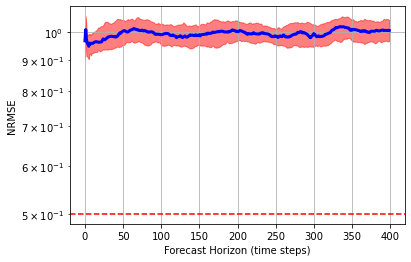

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.963
Median NRMSE at t = 0.5: 1.006
Median NRMSE at t = 1: 0.991
Median NRMSE at t = 2: 1.004
Median NRMSE at t = 3: 0.995


In [55]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.3 Loss coefficients

In [80]:
hidden_size = [36, 32, 32, 24]
max_lag = 16

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

### 3.3.1 Base [1, 1, 0.1, 0.01]
This is done in 3.2.3

### 3.3.2 Increased focus on forward loss [1, 2, 0.1, 0.01]

In [81]:
loss_weights = [1, 2, .1, .01]

In [82]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.79 | Train loss = 0.9698940 | Val loss =  0.9917510
Epoch 20: Time taken = 0.78 | Train loss = 0.8815092 | Val loss =  1.0011160
Epoch 30: Time taken = 0.81 | Train loss = 0.8140455 | Val loss =  1.0192474
Epoch 40: Time taken = 0.78 | Train loss = 0.7531823 | Val loss =  1.0195787
EARLY STOPPING. Epoch 42: Train loss = 0.7374377 | Val loss =  1.1040026
Best Validation MSE: 0.9885751
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.79 | Train loss = 0.8351040 | Val loss =  0.9964994
Epoch 20: Time taken = 0.80 | Train loss = 0.7592881 | Val loss =  1.0270260
Epoch 30: Time taken = 0.78 | Train loss = 0.7183481 | Val loss =  1.3308936
EARLY STOPPING. Epoch 31: Train loss = 0.7161557 | Val loss =  1.3944042
Best Validation MSE: 0.9848762
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.78 | Train loss = 0.8051541 | Val loss =  1.0057550
Epoch 20: Time taken = 0.78 | Train loss = 0.7424662 | Val loss =  1.0967836
Epoch 30: Time taken = 0.7

In [83]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.25


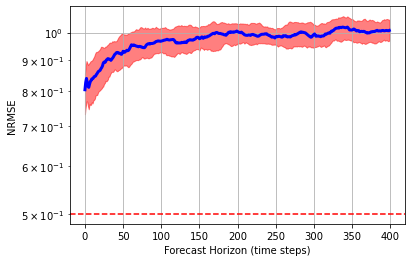

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.866
Median NRMSE at t = 0.5: 0.931
Median NRMSE at t = 1: 0.968
Median NRMSE at t = 2: 1.004
Median NRMSE at t = 3: 0.992


In [84]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.3 Only autoencoder and forward loss [1, 1, 0, 0]

In [85]:
loss_weights = [1, 1, 0, 0]

In [86]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.95 | Train loss = 0.5437190 | Val loss =  0.9894866
Epoch 20: Time taken = 0.90 | Train loss = 0.4682188 | Val loss =  0.9900969
Epoch 30: Time taken = 0.70 | Train loss = 0.4260339 | Val loss =  0.9767399
Epoch 31: Time taken = 0.72 | Train loss = 0.4242312 | Val loss =  0.9752776
Epoch 33: Time taken = 0.73 | Train loss = 0.4208955 | Val loss =  0.9751637
Epoch 38: Time taken = 0.73 | Train loss = 0.4115536 | Val loss =  0.9748932
Epoch 40: Time taken = 0.71 | Train loss = 0.4064210 | Val loss =  0.9821058
Epoch 43: Time taken = 0.71 | Train loss = 0.3950316 | Val loss =  0.9632876
Epoch 50: Time taken = 0.70 | Train loss = 0.3741566 | Val loss =  0.9947790
Best Validation MSE: 0.9632876
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.73 | Train loss = 0.3647620 | Val loss =  0.9813362
Epoch 20: Time taken = 0.70 | Train loss = 0.3519868 | Val loss =  0.9767396
Epoch 30: Time taken = 0.70 | Train loss = 0.3436017 | Val loss =  1.01416

In [87]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.22


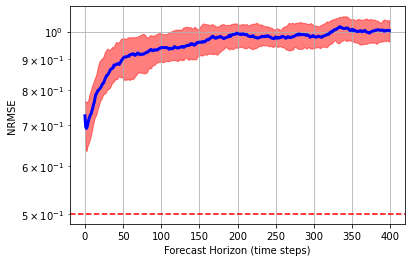

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.806
Median NRMSE at t = 0.5: 0.904
Median NRMSE at t = 1: 0.941
Median NRMSE at t = 2: 0.994
Median NRMSE at t = 3: 0.984


In [88]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.4 Equal weightage to forward and backward dynamic [1, 0.5, 0.5, 0.01]

In [89]:
loss_weights = [1, 0.5, 0.5, 0.01]

In [90]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.68 | Train loss = 0.5718552 | Val loss =  0.9848612
Epoch 20: Time taken = 0.69 | Train loss = 0.5219998 | Val loss =  0.9890185
Epoch 30: Time taken = 0.69 | Train loss = 0.4893889 | Val loss =  0.9951892
Epoch 31: Time taken = 0.69 | Train loss = 0.4848176 | Val loss =  0.9749444
Epoch 40: Time taken = 0.68 | Train loss = 0.4572786 | Val loss =  0.9925173
Epoch 43: Time taken = 0.70 | Train loss = 0.4512873 | Val loss =  0.9714608
Epoch 50: Time taken = 0.70 | Train loss = 0.4416218 | Val loss =  0.9832230
Best Validation MSE: 0.9714608
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.69 | Train loss = 0.4278580 | Val loss =  0.9929746
Epoch 20: Time taken = 0.71 | Train loss = 0.4178621 | Val loss =  0.9938796
Epoch 30: Time taken = 0.68 | Train loss = 0.4142429 | Val loss =  1.0266296
EARLY STOPPING. Epoch 38: Train loss = 0.4105041 | Val loss =  1.1056656
Best Validation MSE: 0.9820848

Epoch 10: Time taken = 0.68 | Train loss = 0.4

In [91]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.23


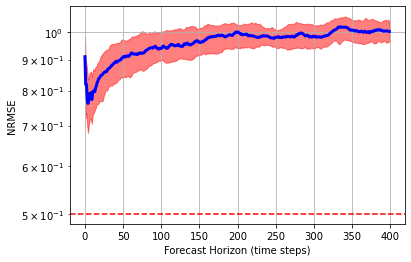

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.844
Median NRMSE at t = 0.5: 0.909
Median NRMSE at t = 1: 0.939
Median NRMSE at t = 2: 0.999
Median NRMSE at t = 3: 0.984


In [92]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.5 Increased and Equal weightage to forward and backward dynamic [1, 1, 1, 0.01]

In [93]:
loss_weights = [1, 1, 1, 0.01]

In [94]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.70 | Train loss = 0.9537262 | Val loss =  0.9779566
Epoch 20: Time taken = 0.69 | Train loss = 0.8496584 | Val loss =  0.9867486
Epoch 30: Time taken = 0.70 | Train loss = 0.8063607 | Val loss =  0.9963588
EARLY STOPPING. Epoch 39: Train loss = 0.7718447 | Val loss =  1.0400187
Best Validation MSE: 0.9697770
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.67 | Train loss = 0.8333548 | Val loss =  0.9868756
Epoch 20: Time taken = 0.67 | Train loss = 0.7768988 | Val loss =  1.0242711
Epoch 30: Time taken = 0.69 | Train loss = 0.7610454 | Val loss =  1.2121850
EARLY STOPPING. Epoch 32: Train loss = 0.7579939 | Val loss =  1.3682230
Best Validation MSE: 0.9750460

Epoch 10: Time taken = 0.68 | Train loss = 0.8091918 | Val loss =  0.9911863
Epoch 20: Time taken = 0.68 | Train loss = 0.7672201 | Val loss =  1.1586276
Epoch 30: Time taken = 0.67 | Train loss = 0.7518759 | Val loss =  1.5616006
EARLY STOPPING. Epoch 34: Train loss = 0.7449436 |

In [95]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.26


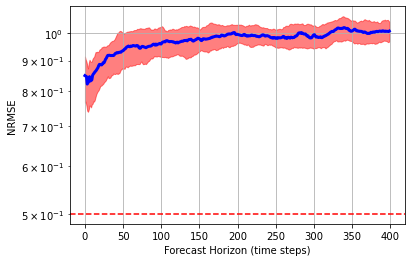

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.886
Median NRMSE at t = 0.5: 0.935
Median NRMSE at t = 1: 0.959
Median NRMSE at t = 2: 0.995
Median NRMSE at t = 3: 0.994


In [96]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 4. Final Model

In [97]:
hidden_size = [36, 32, 32, 24]
max_lag = 16
loss_weights = [1, 1, 0, 0]

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

In [98]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.70 | Train loss = 0.5437190 | Val loss =  0.9894866
Epoch 20: Time taken = 0.72 | Train loss = 0.4682188 | Val loss =  0.9900969
Epoch 30: Time taken = 0.72 | Train loss = 0.4260339 | Val loss =  0.9767399
Epoch 31: Time taken = 0.71 | Train loss = 0.4242312 | Val loss =  0.9752776
Epoch 33: Time taken = 0.70 | Train loss = 0.4208955 | Val loss =  0.9751637
Epoch 38: Time taken = 0.72 | Train loss = 0.4115536 | Val loss =  0.9748932
Epoch 40: Time taken = 0.73 | Train loss = 0.4064210 | Val loss =  0.9821058
Epoch 43: Time taken = 0.72 | Train loss = 0.3950316 | Val loss =  0.9632876
Epoch 50: Time taken = 0.74 | Train loss = 0.3741566 | Val loss =  0.9947790
Best Validation MSE: 0.9632876
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.71 | Train loss = 0.3647620 | Val loss =  0.9813362
Epoch 20: Time taken = 0.73 | Train loss = 0.3519868 | Val loss =  0.9767396
Epoch 30: Time taken = 0.71 | Train loss = 0.3436017 | Val loss =  1.01416

In [99]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.23


In [100]:
save_obj(params, res_folder, "best_params.pkl")

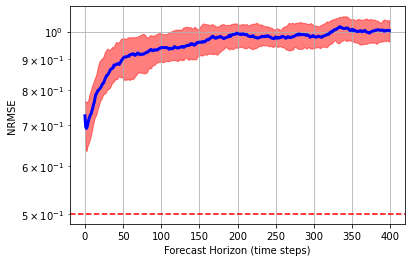

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.806
Median NRMSE at t = 0.5: 0.904
Median NRMSE at t = 1: 0.941
Median NRMSE at t = 2: 0.994
Median NRMSE at t = 3: 0.984


In [101]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 5. Plot images based on Lyapunov Time

In [102]:
res_folder = os.path.join("results", "koopman")

In [103]:
def create_network(hidden_size):
    p1, p2, p3, kappa = hidden_size
    encoder_init, encoder = stax.serial(
        Dense(p1), Tanh,  
        Dense(p2), Tanh,
        Dense(p3), Tanh,
        Dense(kappa))
    decoder_init, decoder = stax.serial(
        Dense(p3), Tanh,
        Dense(p2), Tanh,
        Dense(p1), Tanh,
        Dense(data_dim))
    forward_init, forward = stax.serial(
        Dense_no_bias(kappa))
    backward_init, backward = stax.serial(
        Dense_no_bias(kappa))
    network = (encoder, decoder, forward, backward)
    return network

In [104]:
hidden_size = [36, 32, 32, 24]

In [16]:
# network = create_network(hidden_size)
# params = load_obj(os.path.join(res_folder, "best_params.pkl"))

In [105]:
# mean_pred = get_test_pred(X_test, params, network)
save_obj(mean_pred, "results", "koopman_pred.pkl")

In [106]:
mean_pred = load_obj("results/koopman_pred.pkl")

In [107]:
total_lyapunov_time_pred = 4 / LORENZ_LT # Amount of Lyapunov Time in Test set

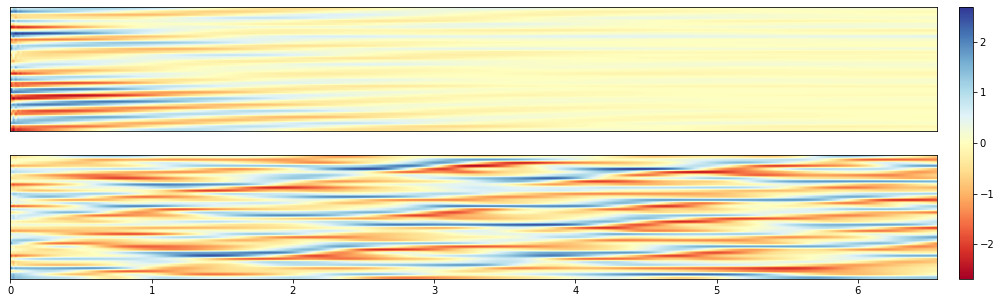

In [108]:
plot_predictions(mean_pred, y_test, total_lyapunov_time_pred, save_name = "lorenz_vsmall_koop", pred_only = True)

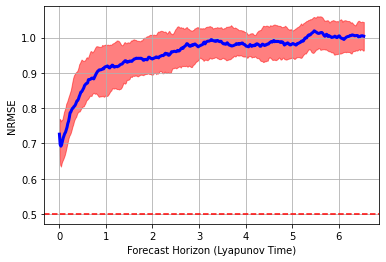

It takes around 0.00 Lyapunov Time for mean error to exceed 0.5

Median NRMSE at 0.5 Lyapunov Time: 0.850
Median NRMSE at 1.0 Lyapunov Time: 0.918
Median NRMSE at 2.0 Lyapunov Time: 0.940
Median NRMSE at 5.0 Lyapunov Time: 0.982


In [109]:
res_single = PointExperimentResultLyapunov(mean_pred - y_test, "lorenz")
res_single.plot_rmse(save_name = "lorenz_vsmall_koopman_ph")
print()
res_single.get_loss()